<a href="https://colab.research.google.com/github/NelisLima/data_science/blob/main/3_machine_learning_classificacador_nivel_estresse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP Machine Learning & Analytics**

**Descrição do projeto**

Objetivo:
Construir um modelo supervisionado para classificar nível de estresse de estudantes a partir dos padrões de vida dos alunos e correlação com desempenho acadêmico.
Os dados utilizados são:
  - Horas de estudo por dia,
  - Horas extracurriculares por dia,
  - Horas de sono por dia,
  - Horas sociais por dia,
  - Horas de atividade física por dia,
  - Desempenho acadêmico (GPA)
  - Nível de estresse (target)

**Fonte dos dados:**
https://www.kaggle.com/datasets/steve1215rogg/student-lifestyle-dataset

Carga dos Dados

In [ ]:
# Importando biliotecas necessárias
import warnings
warnings.filterwarnings("ignore")
import requests
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn. linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve

In [ ]:
# Baixando dataset a ser utilizado

# Definindo a URL do arquivo e a pasta temporária
url = "https://www.kaggle.com/api/v1/datasets/download/steve1215rogg/student-lifestyle-dataset"
temp_dir = "tmp"

if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

file_name = "student-lifestyle-dataset.zip"
file_path = os.path.join(temp_dir, file_name)

# Baixando o arquivo
response = requests.get(url, stream=True)
with open(file_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

print("Arquivo baixado com sucesso para:", file_path)

# Extraindo os arquivos
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Identificando o arquivo CSV
csv_file = [file for file in os.listdir() if file.endswith('.csv')][0]

# Lendo o CSV no pandas
df = pd.read_csv(csv_file)

Arquivo baixado com sucesso para: tmp/student-lifestyle-dataset.zip


Preparação dos dados

In [ ]:
# Analisando as informações abaixo, percebemos que não temos valores nulos, todo o df tem 2.000 linhas. (Não há necessidade de preenchimento de valores nulos)
# Das colunas importantes, será removida a que tem o id do estudante, pois não é interessante para o nosso modelo.

In [ ]:
df.info() #verificando informações gerais do dataset para tratativa

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB


In [ ]:
len(df['Student_ID'].unique()) #verificando se há estudantes duplicados

2000

In [ ]:
# Removendo coluna com id dos estudantes, pois essa coluna não é necessária para a predição
df = df.drop('Student_ID', axis=1)

In [ ]:
df.head() #analisando as primeiras linhas do dataset após exclusão da coluna ID (não identificado necessidadede ajuste)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,8.1,0.6,6.5,2.2,6.6,3.51,High


In [ ]:
df.describe() #analisando a distribuição das features

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,7.475800,1.990100,7.501250,2.704550,4.32830,3.115960
std,1.423888,1.155855,1.460949,1.688514,2.51411,0.298674
min,5.000000,0.000000,5.000000,0.000000,0.00000,2.240000
25%,6.300000,1.000000,6.200000,1.200000,2.40000,2.900000
50%,7.400000,2.000000,7.500000,2.600000,4.10000,3.110000
75%,8.700000,3.000000,8.800000,4.100000,6.10000,3.330000
max,10.000000,4.000000,10.000000,6.000000,13.00000,4.000000


In [ ]:
# Analisando os dois trechos abaixo, percebemos que os atributos estão sem escala padrão (necessidade de padronização, posteriormente será mostrado um comparativo ao gerar os modelos entre dados originais, normalizados e padronizados)

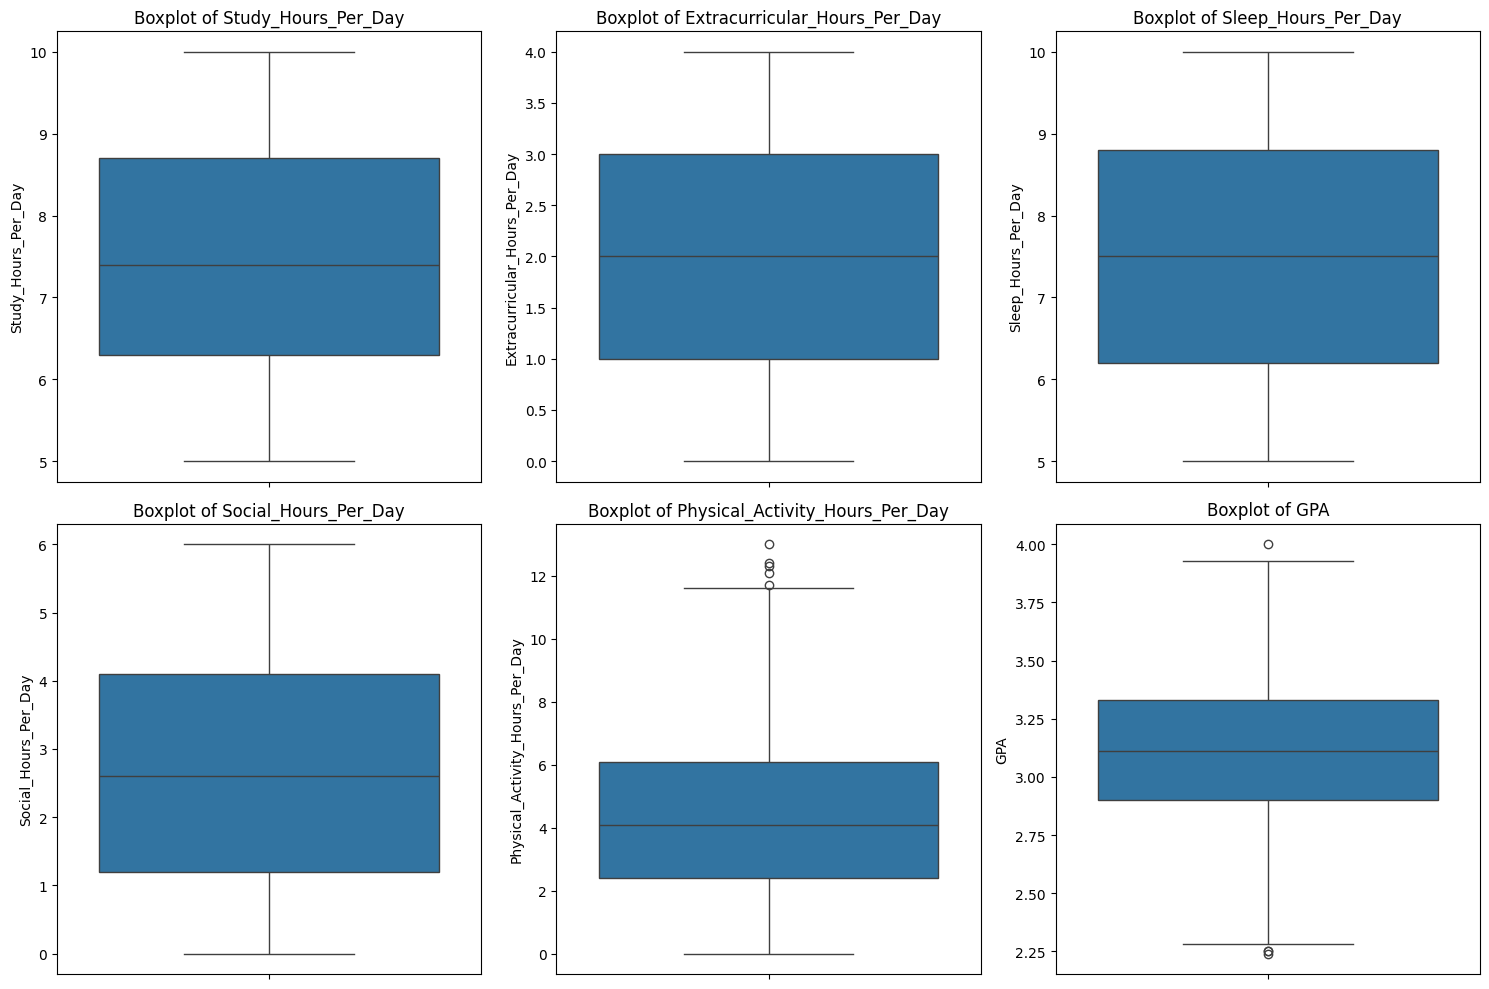

In [ ]:
# Criando uma lista de colunas para plotar, excluindo'Stress_Level'
columns_to_plot = [col for col in df.columns if col != 'Stress_Level']


num_plots = len(columns_to_plot)
num_cols = 3  # Número de colunas na subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols # Calculando o número de linhas necessárias


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Achando a matriz de eixos para facilitar a iteração

for i, col in enumerate(columns_to_plot):
    sns.boxplot(ax=axes[i], y=df[col])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# analisando os trechos abaixo, percebemos o target não está bem distribuído, havendo necessidade de balanceamento

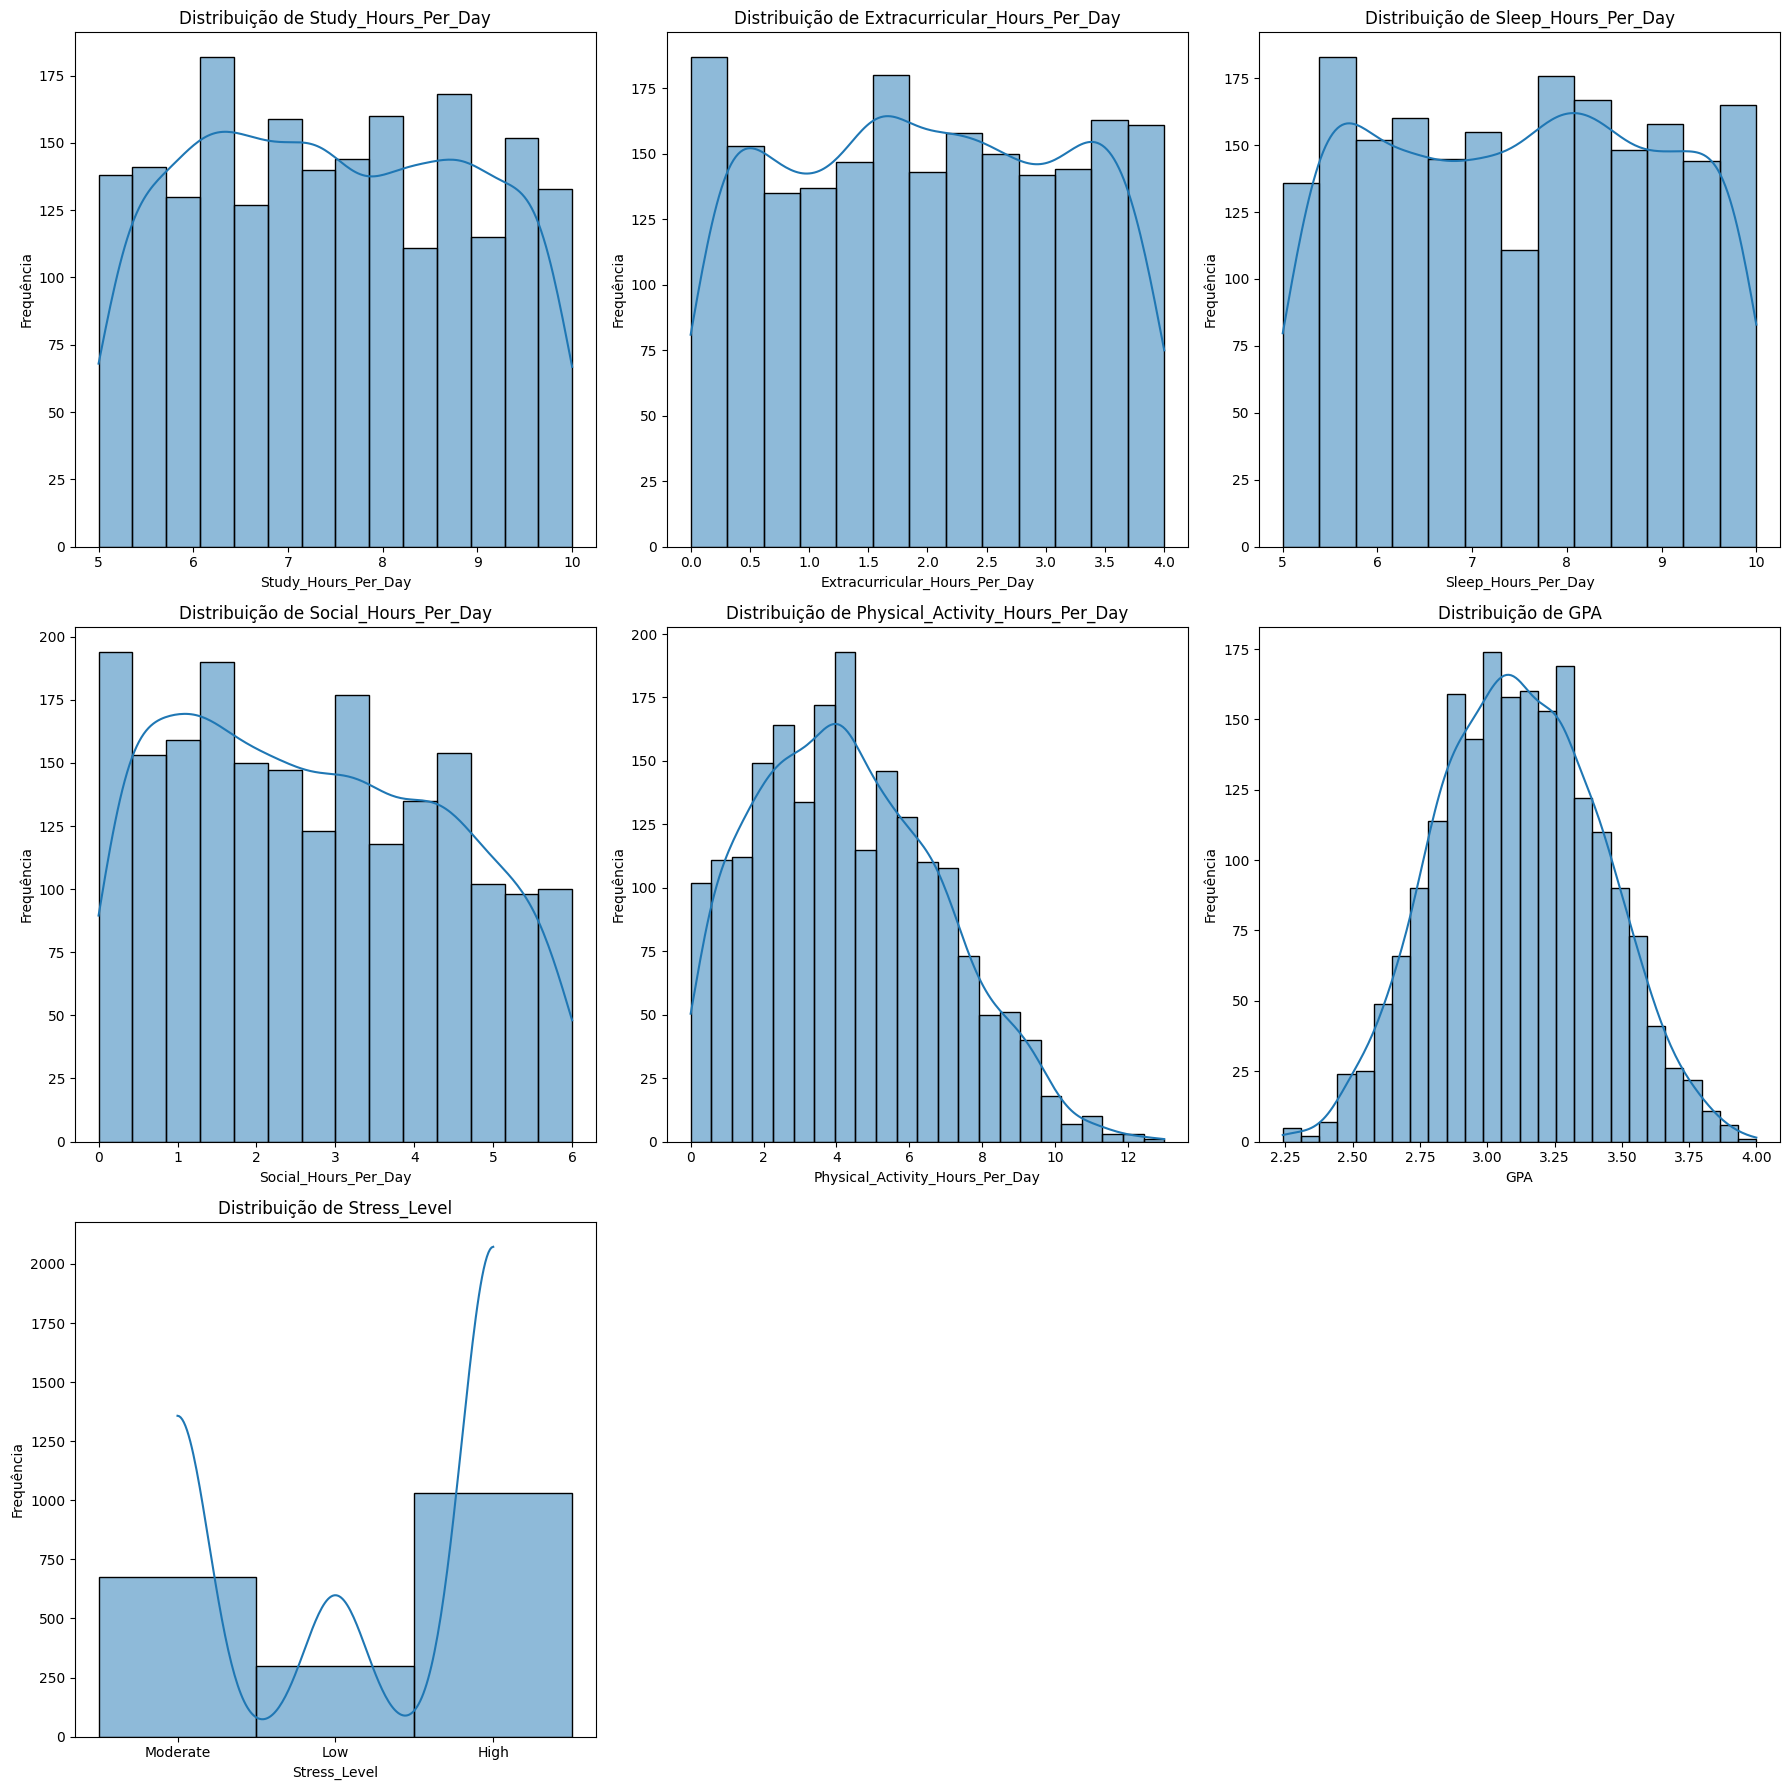

In [ ]:
# Analisando a distribuição das features graficamente

# Plotando a distribuição de cada coluna em um único gráfico com subplots
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3  # Calcula o número de linhas necessárias para 3 colunas
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))

for i, col in enumerate(df.columns):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribuição de {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequência')

# Remove quaisquer eixos extras que não estejam sendo usados
for i in range(num_cols, num_rows * 3):
    row = i // 3
    col_idx = i % 3
    fig.delaxes(axes[row, col_idx])

plt.tight_layout() # Ajusta o layout para evitar sobreposições
plt.show()

Separando o dataset em bases de treino e teste, usando holdout

In [ ]:
# Definir tamanho do conjunto de teste e semente aleatória
test_size = 0.20  # Tamanho do conjunto de teste
seed = 8  # Semente aleatória

# Separação dos dados em atributos (X) e target (y)
array = df.values
x = array[:, 0:6]  # Atributos
y = array[:, 6]    # Target

# Codificar o target (y) de string para valores numéricos usando Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir os dados em treino e teste (antes de balancear)
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded,  # Usar o target codificado
    test_size=test_size,
    random_state=seed,  # Define a semente para garantir reprodutibilidade
    shuffle=True,       # Embaralha os dados antes de dividir
    stratify=y_encoded  # Garante a proporção das classes nos conjuntos de treino e teste
)  # Holdout com estratificação

# Aplicar SMOTE apenas ao conjunto de treino
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)  # Validação cruzada com estratificação


Modelagem

In [ ]:
# Serão avaliados diversos algoritmos para verificação de melhor performance em diferentes algoritmos, usando a validação cruzada para treinar e avaliar através da acurácia, usando a configuração padrão

In [ ]:
# Abaixo o modelo escolhido foi o SVM, pois apresenta melhores resultados tanto na média das predições quanto no desvio padrão.

LR-orig: 0.826 (0.036)
KNN-orig: 0.907 (0.029)
NB-orig: 0.853 (0.038)
SVM-orig: 0.943 (0.019)
Voting-orig: 0.971 (0.012)
LR-padr: 0.824 (0.036)
KNN-padr: 0.891 (0.030)
NB-padr: 0.853 (0.038)
SVM-padr: 0.951 (0.024)
Voting-padr: 0.971 (0.019)
LR-norm: 0.818 (0.033)
KNN-norm: 0.902 (0.038)
NB-norm: 0.853 (0.038)
SVM-norm: 0.951 (0.022)
Voting-norm: 0.970 (0.015)


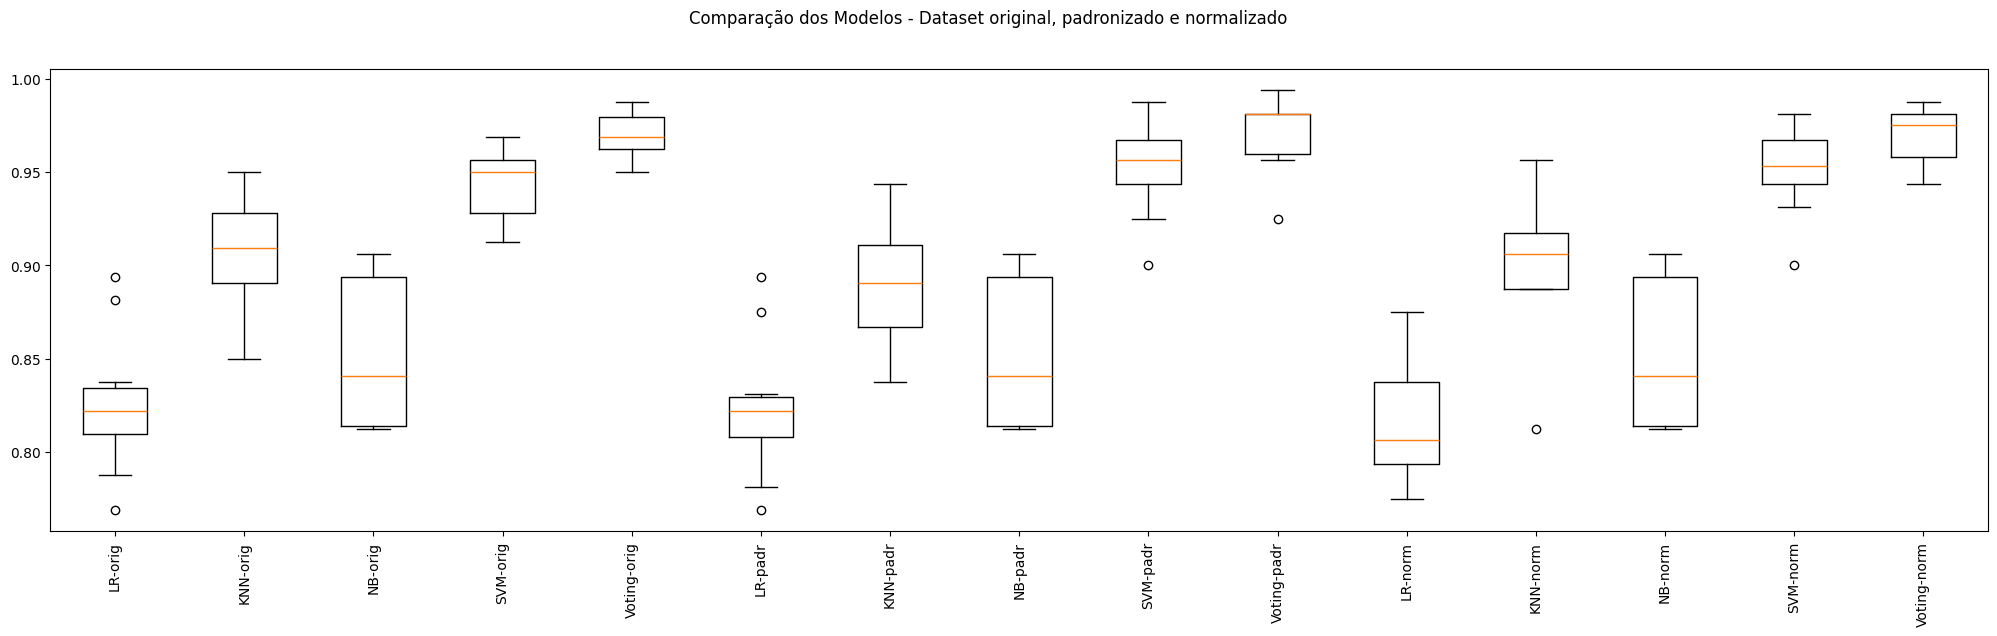

In [ ]:
np.random.seed(7)  # Definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o Baggingclassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Criando o VotingClassifier
voting = ('Voting', VotingClassifier(estimators=bases, voting='hard'))  # Aqui estamos usando 'hard voting'

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())  # Padronização
min_max_scaler = ('MinMaxScaler', MinMaxScaler())  # Normalização

# Montando os pipelines

pipelines = []
results = []
names = []

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Voting-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Voting-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Voting-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())  # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


In [ ]:
# Abaixo avaliando o modelo com diferentes hiperparâmetros, identificamos que teve um melhor comportamento com o datset com seus dados normalizados (voting-norm - Melhor Score: 0.983125).

In [ ]:
# abaixo avaliamos o modelo e melhores hiperparâmetros escolhidos na base de treino e analisamos a acurácia.

In [ ]:
# Definindo os componentes do pipeline
model1 = ('logistic', LogisticRegression(max_iter=200))  # Logistic Regression
model2 = ('cart', DecisionTreeClassifier())  # Decision Tree
model3 = ('svm', SVC())  # Support Vector Machine

# Transformações
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Pipelines para VotingClassifier
pipelines = []
pipelines.append(('voting-orig', Pipeline(steps=[('voting', VotingClassifier(estimators=[model1, model2, model3], voting='hard'))])))
pipelines.append(('voting-padr', Pipeline(steps=[standard_scaler, ('voting', VotingClassifier(estimators=[model1, model2, model3], voting='hard'))])))
pipelines.append(('voting-norm', Pipeline(steps=[min_max_scaler, ('voting', VotingClassifier(estimators=[model1, model2, model3], voting='hard'))])))

# Grade de parâmetros para o VotingClassifier
param_grid = {
    'voting__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]],  # Diferentes combinações de pesos para os modelos base
}

# Definir a validação cruzada e o scoring
scoring = 'accuracy'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)  # Validação cruzada com estratificação

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    # Realizando o GridSearchCV para cada pipeline
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(x_train, y_train)

    # Imprime a melhor configuração e o desempenho
    print("Pipeline: %s - Melhor Score: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Pipeline: voting-orig - Melhor Score: 0.978750 usando {'voting__weights': [1, 2, 1]}
Pipeline: voting-padr - Melhor Score: 0.981875 usando {'voting__weights': [1, 2, 1]}
Pipeline: voting-norm - Melhor Score: 0.983125 usando {'voting__weights': [1, 2, 1]}


In [ ]:
# Analisando a matriz de confusão abaixo mostra que poucos casos foram previstos de forma errada pelo modelo

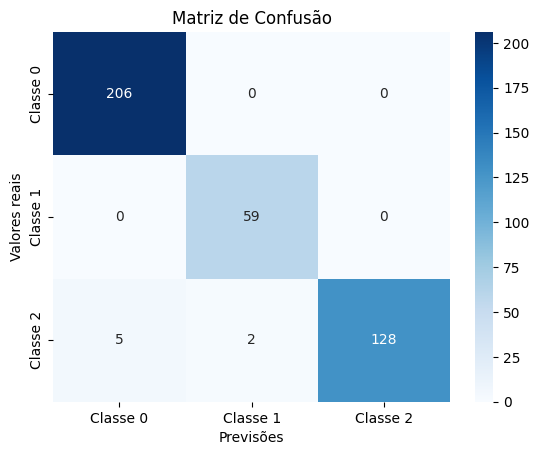

In [ ]:
# Fazer as previsões
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)

# Calcular e plotar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotando a matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1', 'Classe 2'], yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel('Previsões')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
# Analisando as medidas abaixo

# A precisão do modelo acima está muito boa, indicando uma alte precisão nos casos positivos em relação ao todo.
# O recall acima está muito bom, indicando uma boa precisão ao identificar casos positivos corretamente classificados.
# Temos uma boa harmonia no F1-score, mostrando equilíbrio entre exemplos positivos e predições corretas.

In [ ]:
# Calcular precisão, recall e F1-score para classificação multiclasse

predictions = best_model.predict(x_test)
precision = precision_score(y_test, predictions, average='macro')  # 'micro', 'macro', 'weighted', ou 'None'
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Precisão: 0.9811721440965478
Recall: 0.9827160493827161
F1-Score: 0.9815756520259078


In [ ]:
# Analisando a curva ROC abaixo:
# AUC classe 0 = 0,93: A classe 0 tem uma AUC de 0,93, significa que o modelo tem 93% de chance de classificar corretamente a classe 0 quando comparada a uma classe aleatória. Isso é muito bom, já que AUC próxima de 1 indica um modelo eficiente.

# AUC classe 1 = 1,0: A classe 1 tem uma AUC de 1,0, o que significa que o modelo é perfeito ao distinguir essa classe das outras. Ele classifica todos os exemplos dessa classe corretamente, sem nenhum erro, o que é excelente.

# AUC classe 2 = 0,92: A classe 2 tem uma AUC de 0,92, que também é muito boa, indicando que o modelo é muito eficaz em distinguir a classe 2 de outras classes.

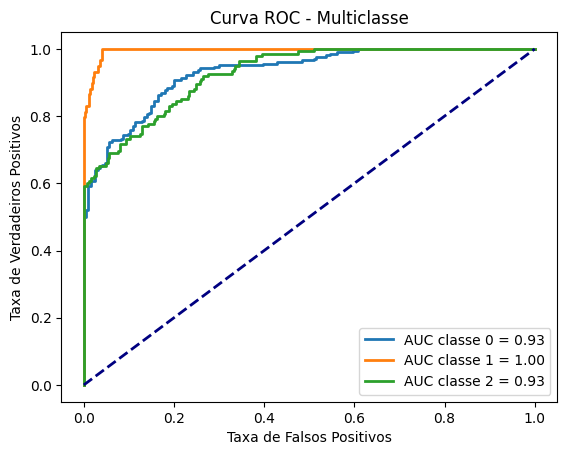

In [ ]:
best_model = grid.best_estimator_  # Pega o melhor modelo do GridSearch

# Criando o modelo One-vs-Rest com o melhor modelo do SVC encontrado pelo GridSearch e garantindo que 'probability=True'
ovr_model = OneVsRestClassifier(SVC(kernel='linear', probability=True))

# Treinando o modelo
ovr_model.fit(x_train, y_train)

# Probabilidades de cada classe para o conjunto de teste
y_score = ovr_model.predict_proba(x_test)

# Calcular as curvas ROC para cada classe
fpr = {}
tpr = {}
roc_auc = {}

n_classes = len(set(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando a curva ROC
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'AUC classe {i} = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Multiclasse')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Exibindo as classes originais associadas aos números codificados para entender curva de acordo com as classes reais.
print(label_encoder.classes_)

['High' 'Low' 'Moderate']


In [ ]:
# As medidas abaixo reforçam o quanto o modelo está bom, pois apresenta melhores resultados tanto na média das predições quanto no desvio padrão usando o dataset bruto

In [ ]:
# Realizando validação cruzada
cv_scores = cross_val_score(model, x, y, cv=10)

# Exibindo a média e desvio padrão das pontuações
print(f"Acurácia média: {cv_scores.mean()}")
print(f"Desvio padrão: {cv_scores.std()}")


Acurácia média: 0.9730000000000001
Desvio padrão: 0.014696938456699083


In [ ]:
# Um bom desempenho na base de treino e na base de teste, mostra que o modelo está generelizando bem

In [ ]:
# Ajuste o modelo aos dados de treino
best_model.fit(x_train, y_train)

# Acurácia no treinamento
train_accuracy = best_model.score(x_train, y_train)

# Acurácia no teste
test_accuracy = best_model.score(x_test, y_test)

print(f"Acurácia no treinamento: {train_accuracy}")
print(f"Acurácia no teste: {test_accuracy}")


Acurácia no treinamento: 0.9875
Acurácia no teste: 0.9825


In [ ]:
# Se a curva de treinamento vai aumentando e a curva de teste segue esse comportamento e se aproxima, isso é um bom sinal de que o modelo está aprendendo e melhorando sua performance com o tempo, sem sinais de overfitting ou underfitting. A diferença entre elas pode ser normal, especialmente no começo do treinamento, e a tendência de ambas se aproximarem indica uma boa capacidade de generalização.

# Esses resultados, onde a acurácia de teste começa abaixo e termina abaixo da de treinamento, mas ambas estão aumentando, são um sinal positivo de que seu modelo está se ajustando bem.

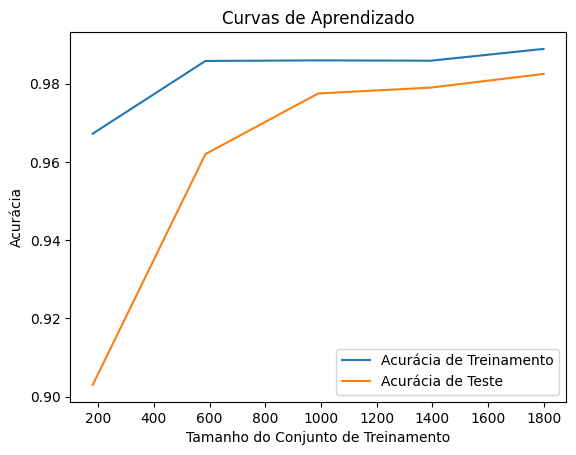

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model, x, y, cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Acurácia de Treinamento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Acurácia de Teste')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.title('Curvas de Aprendizado')
plt.legend()
plt.show()


# **Checklist**

**Objetivo:** Construir um modelo supervisionado para classificar nível de estresse de estudantes a partir dos padrões de vida dos alunos e correlação com desempenho acadêmico. Os dados utilizados são:

# **Qual é a descrição do problema?**
Entender nível de estresse de estudantes a partir de padrões de vida e correlação acadêmica.

# **Você tem premissas ou hipóteses sobre o problema? Quais?**
O nível de estresse vão variar de acordo com os padrões analisados.

# **Que restrições ou condições foram impostas para selecionar os dados?**
Utilizamos uma base gerada a partir de uma pesquisa realizada com 2.000 estudantes principalmente de Índia entre agosto de 2023 e maio de 2024.

# Descreva o seu dataset (atributos, imagens, anotações, etc).
O dataset possui 2000 linhas cada uma correspondente a cada aluno, no dataset original temos 8 colunas:
- Student_ID
- Study_Hours_Per_Day
- Extracurricular_Hours_Per_Day
- Sleep_Hours_Per_Day
- Social_Hours_Per_Day
- Physical_Activity_Hours_Per_Day
- GPA
- Stress_Level

Sem valores nulos.

# **Preparação de Dados**

Objetivo: realizar operações de preparação dos dados.

# **Separe o dataset entre treino e teste (e validação, se aplicável).**
Feito

# **Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.**
Sim, para que o modelo seja treinado e avaliado de forma mais eficiente.

# Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.
Feito o comparativo com dados originais, normalizados e padronizados.

# **Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.**
Feito, removida a coluna com id do estudante.

# **Modelagem e treinamento:**

Objetivo: construir modelos para resolver o problema em questão.

# Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.
Os modelos avaliados foram Regressão Logística, KNN, CART, Naive Bayes, SVC e Voting (Regressão Logistica, CART e SVM). Todos podem ser usados para classificação.

Foi escolhido o Voting, pois ao comparar a média e desvio padrão na validação cruzada entre base original, normalizada e padronizada, teve um ótimo desempenho em comparação aos outros algoritmos.

# Há algum ajuste inicial para os hiperparâmetros?
Inicialmente não, utilizei a configuração padrão, posteriormente usei o GridSearchCV para encontrar a melhor configuração de hiperparâmetro e dataset.

# O modelo foi devidamente treinado? Foi observado problema de underfitting?
Foi bem treinado pois não  tive problemas de baixo resultado nas medidas de performance como acurácia, F1-score e recall e precision, e na curva de roc também tivemos um bom desempenho.

# É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
Sim, usei o GridSearchCV no modelo escolhido para saber qual hiperparâmetro utilizar.

# Há algum método avançado ou mais complexo que possa ser avaliado?
Acredito que não, pois comparamos diversos modelos e analisamos as métricas no modelo escolhido.

# Posso criar um comitê de modelos diferentes para o problema (ensembles)?
Poderia mas utilize Voting, que teve uma acurácia de 98%


# Avaliação de Resultados:

Objetivo: analisar o desempenho dos modelos gerados em dados não vistos (com a base de teste)

# Selecione as métricas de avaliação condizentes com o problema, justificando.
Usei a **matriz de confusão**, pois estamos analisando um modelo de classificação e assim saberemos quais classes está prevendo da melhor foma e quais estão sendo classificados de forma incorreta.
**Precisão** a se sabe o nível em casos positivos em relação ao todo.
O **recall** para mensurar casos positivos corretamente classificados.
**F1-score**, para saber se temos harmonia entre exemplos positivos e predições corretas.
E curva ROC, para entender o comportamento da acurácia por classe.

# Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste.
Feito o treino, e no teste continuou performando muito bem.

# Os resultados fazem sentido?
Sim, pois ao o testar com a base de teste, a performance se manteve em 97% sem estar normalizada.

# Foi observado algum problema de overfitting?
Não, ao comparar o resultado entre base de treino e teste, o resultado se manteve, dá pra observar também na curva de aprendizado, quanto mais dados mais o modelo performa bem se vai seguindo a tendência da base de treino na base de teste.

# Compare os resultados de diferentes modelos.
Feito.

# Descreva a melhor solução encontrada, justificando.
Inicialmente foram analisados diferentes modelos a partir da  validação cruzada e analizando a média da acurácia e seu desvio padrão: notamos que o melhor resultado foi em Voting-padr: 0.974 (0.018)

- LR-orig: 0.823 (0.020)
- KNN-orig: 0.912 (0.041)
- NB-orig: 0.853 (0.030)
- SVM-orig: 0.943 (0.022)
- Voting-orig: 0.969 (0.019)
- LR-padr: 0.821 (0.018)
- KNN-padr: 0.896 (0.028)
- NB-padr: 0.853 (0.030)
- SVM-padr: 0.951 (0.026)
- Voting-padr: 0.974 (0.018)
- LR-norm: 0.815 (0.023)
- KNN-norm: 0.912 (0.032)
- NB-norm: 0.853 (0.030)
- SVM-norm: 0.954 (0.029)
- Voting-norm: 0.971 (0.019)

Porém ao usar criar ao avaliar pela pipeline e usar o GridSearchCV para testar com diferentes hiperparâmetros, encontramos o melhor resultado na base normalizada:

Pipeline: voting-norm - Melhor Score: 0.983125 usando {'voting__weights': [1, 2, 1]}

Após escolher a melhor base e hiperparâmetro, foram aplicadas a métricas e análises de performance do modelo:

Foi testado o modelo na base de teste e o resultado da acurácia se manteve em 0.9825, o que mostra uma boa generalização.

A medidas de Precisão: 0.9811, Recall: 0.9827, F1-Score: 0.9815 se mantiveram em 98%. O que mostra uma boa detecção em casos positivos em relação a todo o dataset, boa precisão e identficar casos positivos e uma boa harmonia entre essas duas métricas.

E então analisando o gráfico com as curvas de aprendizado, percebe-se que a acurácia na base de teste vai se aproximando da acurácia na base de treino ao aumentar a quantidade de dados, o que mostra um boa generalização.